# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

plt.rcParams['figure.figsize'] = (5, 4)

In [39]:
# data file: https://www.marketwatch.com/investing/stock/sbux/download-data?startDate=1/1/2021&endDate=11/27/2024
data_file = 'C:\\Users\\stefa\\Documents\\workspaces\\szx81\\SBUX\\test_data\\SBUX0_1D_1.01.2021-27.11.2024.csv'
data = pd.read_csv(data_file, index_col = 'Date', parse_dates=True)
data['Volume'] = data['Volume'].apply(lambda x: float(x.replace(',', '')))

training_data_count = 200
training_data = data[:training_data_count:].copy(deep=True)
testing_data = data[training_data_count:].copy(deep=True)

print(f'total data length: {len(data)}')
print(f'training data length: {len(training_data)}')
print(f'testing data length: {len(testing_data)}')
data.head(5)

total data length: 254
training data length: 200
testing data length: 54


,Open,High,Low,Close,Volume
Date,,,,,
2024-11-27,100.75,102.03,100.72,101.51,4857843.0
2024-11-26,101.99,102.09,100.47,100.68,6558260.0
2024-11-25,102.93,103.32,101.78,101.84,8839592.0
2024-11-22,100.00,102.56,99.77,102.50,6563290.0
2024-11-21,99.50,100.33,98.49,100.06,6760622.0


In [40]:
data['Close']


Date
2024-11-27    101.51
2024-11-26    100.68
2024-11-25    101.84
2024-11-22    102.50
2024-11-21    100.06
               ...  
2023-12-01     99.20
2023-11-30     99.30
2023-11-29     99.85
2023-11-28    101.18
2023-11-27    102.36
Name: Close, Length: 254, dtype: float64

<Axes: title={'center': 'Star Bucks Stock "Close"'}, xlabel='Date'>

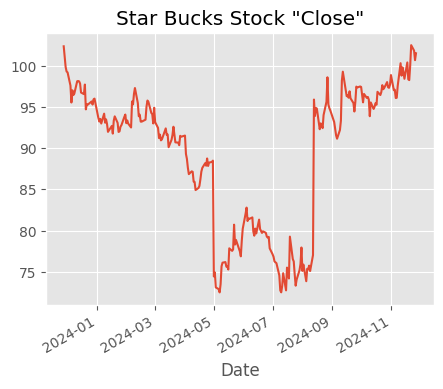

In [41]:
plt.style.use('ggplot')
data['Close'].plot(label='CLOSE', title='Star Bucks Stock "Close"')

In [42]:
def data_preprocessing(df):
    X = StandardScaler().fit_transform(df.iloc[:, 0:]) # all columns
    X = Variable(torch.Tensor(X))
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = MinMaxScaler().fit_transform(df.iloc[:, 3:4] ) # 'Close' column
    y = Variable(torch.Tensor(y))

    return X, y

def nn_trening_result(lstm, df, offset=0, label='', color='blue', alpha=1, verbose=None):
    mm = MinMaxScaler()
    ss = StandardScaler()

    ss.fit_transform(df.iloc[:, 0:]) # all columns
    mm.fit_transform(df.iloc[:, 3:4] ) # 'Close' column

    X = ss.transform(df.iloc[:, 0:]) #old transformers
    X = Variable(torch.Tensor(X)) #converting to Tensors
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))
    
    y = mm.transform(df.iloc[:, 3:4]) #old transformers
    y = Variable(torch.Tensor(y))    #reshaping the dataset

    dataY_plot = y.data.numpy()
    dataY_plot = mm.inverse_transform(dataY_plot)

    nn_answer = lstm(X)#forward pass

    if verbose is not None:
        print(f'''
              {verbose}
formatted feature data (length is {len(df)}): 
    {df[:1]}

NN question[:1] (length is {len(X)}):
    {X[:1]}
NN answer[:5] (length is {len(nn_answer)}): 
    {nn_answer[:1]}
              ''')

    data_predict = nn_answer.data.numpy() #numpy conversion
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    time = [_ for _ in range(offset, offset + len(df))]

    plt.plot(time, dataY_plot, label=label + '- Actual Data', color='black', alpha=0.2, linewidth=5) #actual plot
    plt.plot(time, data_predict, label=label + '- Predicted Data', color=color, alpha=alpha) #predicted plot
    plt.title('Time-Series Prediction')

In [43]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [44]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [45]:
X_train_tensors_final, y_train_tensors = data_preprocessing(training_data)
lstm = LSTM1(num_classes, input_size, hidden_size, 
             num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [46]:
criterion = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [47]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_tensors_final) # forward pass
  optimizer.zero_grad() # initiate gradient
  loss = criterion(outputs, y_train_tensors) # loss function
  loss.backward() # calculate the loss
  optimizer.step() # try to decrease loss, back-prop

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.17860
Epoch: 100, loss: 0.01034
Epoch: 200, loss: 0.00457
Epoch: 300, loss: 0.00316
Epoch: 400, loss: 0.00130
Epoch: 500, loss: 0.00063
Epoch: 600, loss: 0.00051
Epoch: 700, loss: 0.00043
Epoch: 800, loss: 0.00037
Epoch: 900, loss: 0.00031



              Training results test
formatted feature data (length is 54): 
                 Open   High    Low  Close     Volume
Date                                             
2024-02-13  94.85  95.56  93.39  93.87  8138495.0

NN question[:1] (length is 54):
    tensor([[[-0.2227, -0.2006, -0.4344, -0.5617, -0.2552]]])
NN answer[:5] (length is 54): 
    tensor([[0.3554]], grad_fn=<SliceBackward0>)
              


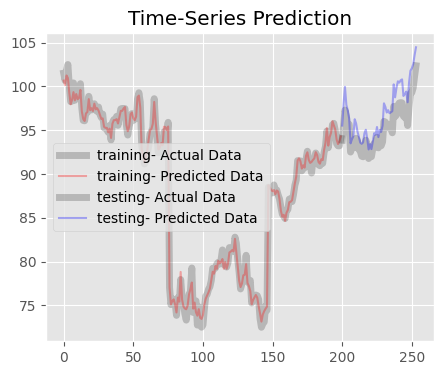

In [48]:
# print(f'training data length: {len(training_data)}')
# print(f'testing data length: {len(testing_data)}')

nn_trening_result(lstm, training_data, 
        label='training', color='red', alpha=0.3)
nn_trening_result(lstm, testing_data, verbose='Training results test',
        offset=len(training_data), label='testing', color='blue', alpha=0.3)
plt.legend()
plt.show() 

In [49]:
print(lstm)

LSTM1(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)
